In [2]:
import sys
sys.path.append("..")

from data_transformation.db_env import DbEnv, db

# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering

# 1.Preprocessing

In [4]:
#get song_num list

conn, cursor = DbEnv().connect_sql()
sql = "SELECT DISTINCT num FROM daily_music_cow"
num_list = DbEnv().get_data_from_table(cursor, sql)
num_list = [item[0] for item in num_list]
print(num_list)

[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 167, 168, 169, 171, 173, 174, 175, 176, 177, 178, 179, 180, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 202, 204, 206, 207, 208, 211, 212, 216, 218, 219, 221, 224, 225, 230, 231, 233, 237, 238, 240, 258, 261, 262, 265, 267, 274, 311, 322, 345, 373, 382, 420, 460, 461, 462, 464, 465, 466, 467, 468, 469, 470, 471, 472, 474, 475, 477, 478, 479, 480, 481, 482, 483, 484, 485

In [12]:
df_price = pd.DataFrame()

# find shortest date length to fit all songs
for num in num_list:
    sql = "SELECT date, price FROM daily_music_cow WHERE num = %s" % num
    df_temp = db(cursor, sql).dataframe
    df_temp = df_temp.set_index('date')
    df_temp.columns = ["%d" % num]

    df_price = pd.concat([df_price, df_temp], axis=1)

print(df_price)
df_price.to_pickle("../storage/df_price.pkl")

               26     27     28     29     30     31     32     33     34  \
date                                                                        
2021-06-03  29000  26000  24000  52800  13500  16100  10300  14500  36400   
2021-06-04  29000  26000  24000  52800  13500  16100  10300  14500  36400   
2021-06-05  29000  26000  23700  52800  13500  16100  10800  14500  36400   
2021-06-06  28500  26000  23500  52800  13500  16100  10800  14500  36400   
2021-06-07  29100  26000  24900  52800  13500  15100  10800  14500  36400   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2021-11-23  29000  43000  29800  90700  19100  70100  15100  37200  40000   
2021-11-24  28500  43000  29900  90700  19100  70000  15000  37200  40000   
2021-11-25  27900  43000  29800  90700  19100  70000  15000  37200  40000   
2021-11-26  30000  43000  31200  90700  19100  70000  15000  37200  40000   
2021-11-27  27000  43000  29100  90700  19000  70000  16100  37200  40000   

In [21]:
# 결측치 제거를 통해 date 맞춰주기
df_price = pd.read_pickle('../storage/df_price.pkl')
df_price_droped = df_price.dropna(axis=0)
list_price_droped = list(df_price_droped.columns)

print(df_price_droped)

               26     27     28     29     30     31     32     33     34  \
date                                                                        
2021-07-06  24000  23000  19000  60500  12900  22000   8900  13900  18200   
2021-07-07  24000  23000  19000  60500  12900  22000   8900  11500  18200   
2021-07-08  24000  23000  19000  60500  12900  22000   9000  13500  18200   
2021-07-09  23900  23000  17800  60500  12900  22000  10800  13500  18200   
2021-07-10  23800  17000  16600  60500  12900  22000  10800  13500  20300   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2021-11-23  29000  43000  29800  90700  19100  70100  15100  37200  40000   
2021-11-24  28500  43000  29900  90700  19100  70000  15000  37200  40000   
2021-11-25  27900  43000  29800  90700  19100  70000  15000  37200  40000   
2021-11-26  30000  43000  31200  90700  19100  70000  15000  37200  40000   
2021-11-27  27000  43000  29100  90700  19000  70000  16100  37200  40000   

In [25]:
# MinMaxScaler로 정규화
array_price_scaled = MinMaxScaler().fit_transform(df_price_droped)
df_price_scaled = pd.DataFrame(array_price_scaled)
df_price_scaled.columns = list_price_droped
df_price_scaled.index = df_price_droped.index
print(df_price_scaled)

                  26        27        28        29        30        31  \
date                                                                     
2021-07-06  0.018939  0.197015  0.067797  0.159490  0.063348  0.021299   
2021-07-07  0.018939  0.197015  0.067797  0.159490  0.063348  0.021299   
2021-07-08  0.018939  0.197015  0.067797  0.159490  0.063348  0.021299   
2021-07-09  0.015152  0.197015  0.033898  0.159490  0.063348  0.021299   
2021-07-10  0.011364  0.017910  0.000000  0.159490  0.063348  0.021299   
...              ...       ...       ...       ...       ...       ...   
2021-11-23  0.208333  0.794030  0.372881  0.400319  0.156863  0.271169   
2021-11-24  0.189394  0.794030  0.375706  0.400319  0.156863  0.270649   
2021-11-25  0.166667  0.794030  0.372881  0.400319  0.156863  0.270649   
2021-11-26  0.246212  0.794030  0.412429  0.400319  0.156863  0.270649   
2021-11-27  0.132576  0.794030  0.353107  0.400319  0.155354  0.270649   

                  32        33       

# 2. Clustering

## (1) SOM

In [27]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(array_price_scaled))))


som = MiniSom(som_x, som_y,len(array_price_scaled[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(array_price_scaled)
som.train(array_price_scaled, 50000)

In [28]:
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

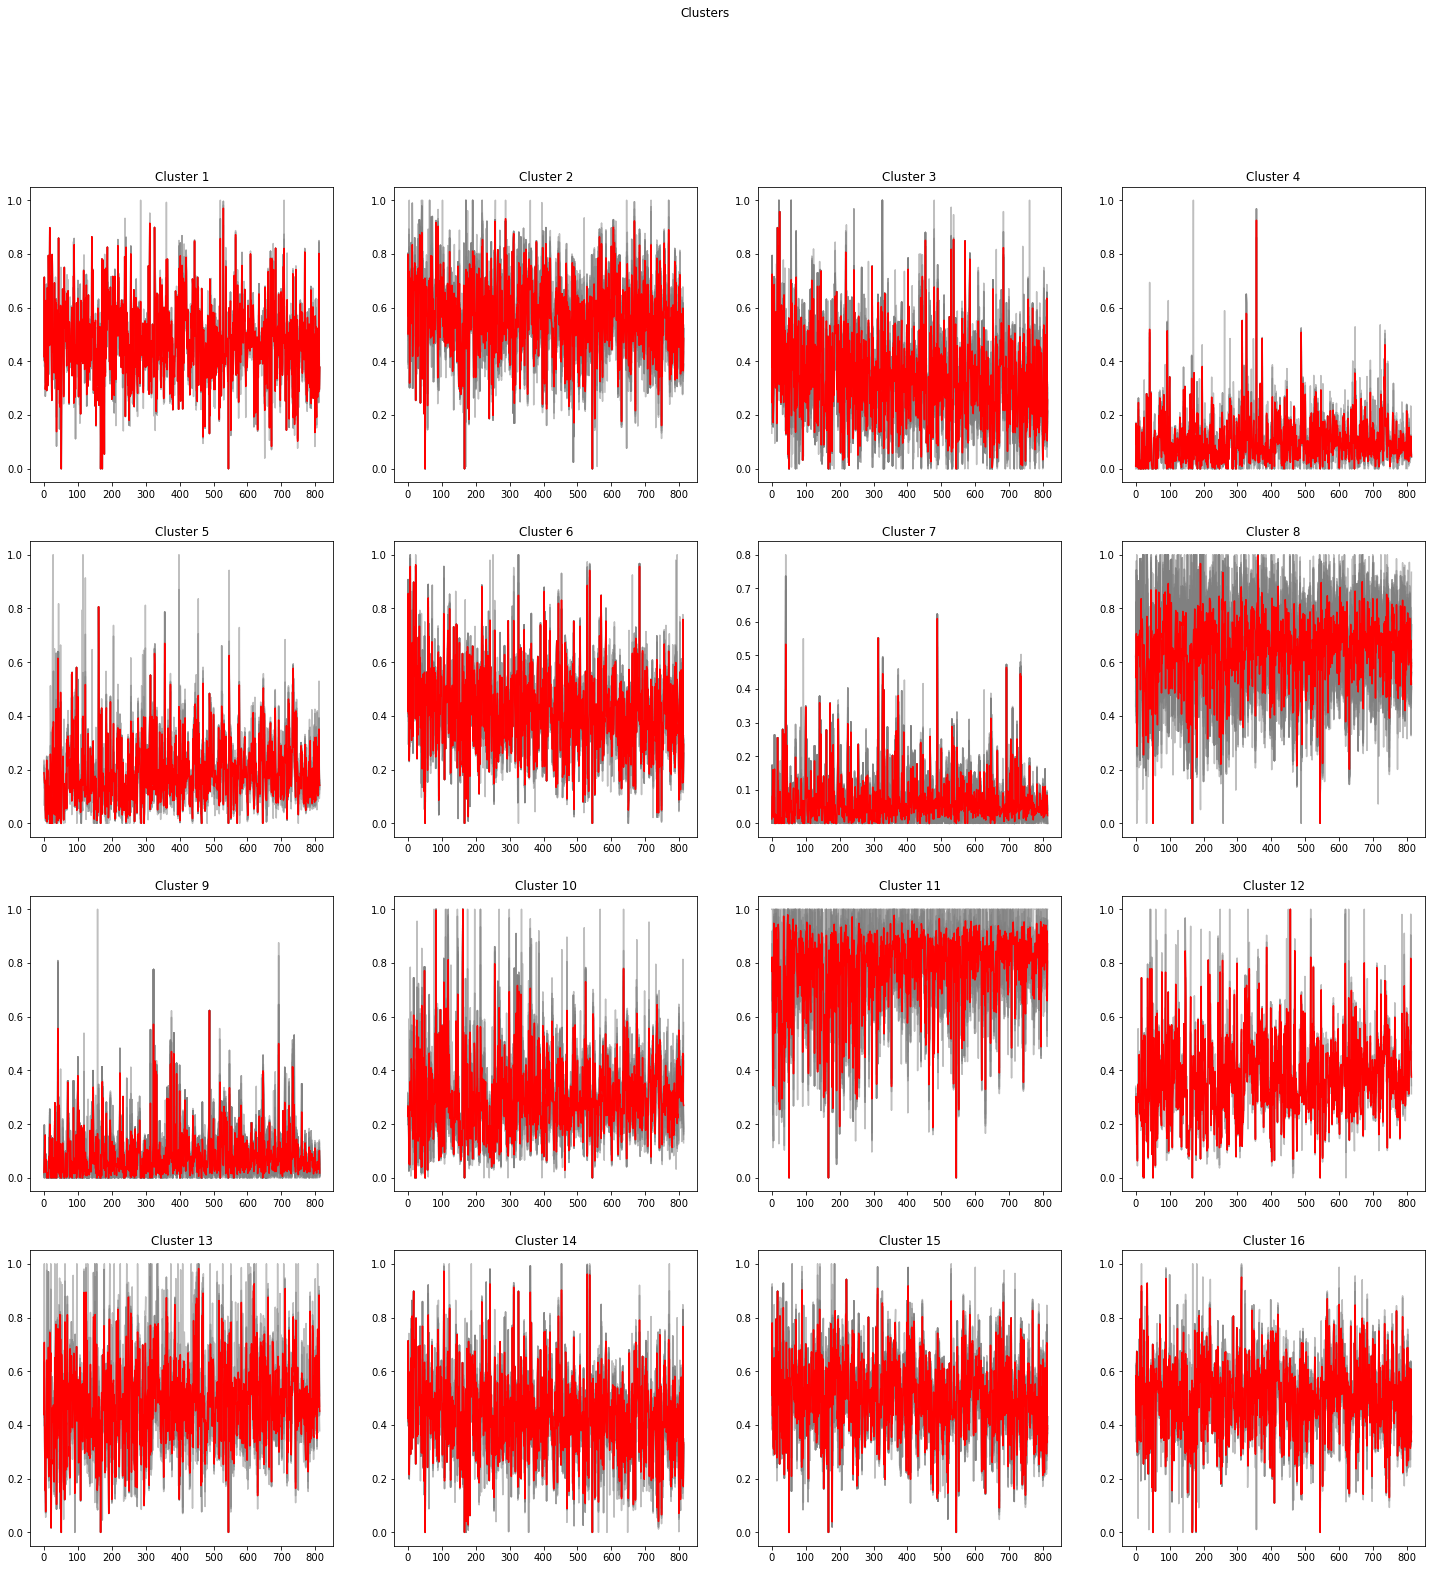

In [29]:
win_map = som.win_map(array_price_scaled)

plot_som_series_averaged_center(som_x, som_y, win_map)

## 2. Dynamic Time Warping Barycenter Averaging (DBA)

In [30]:
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

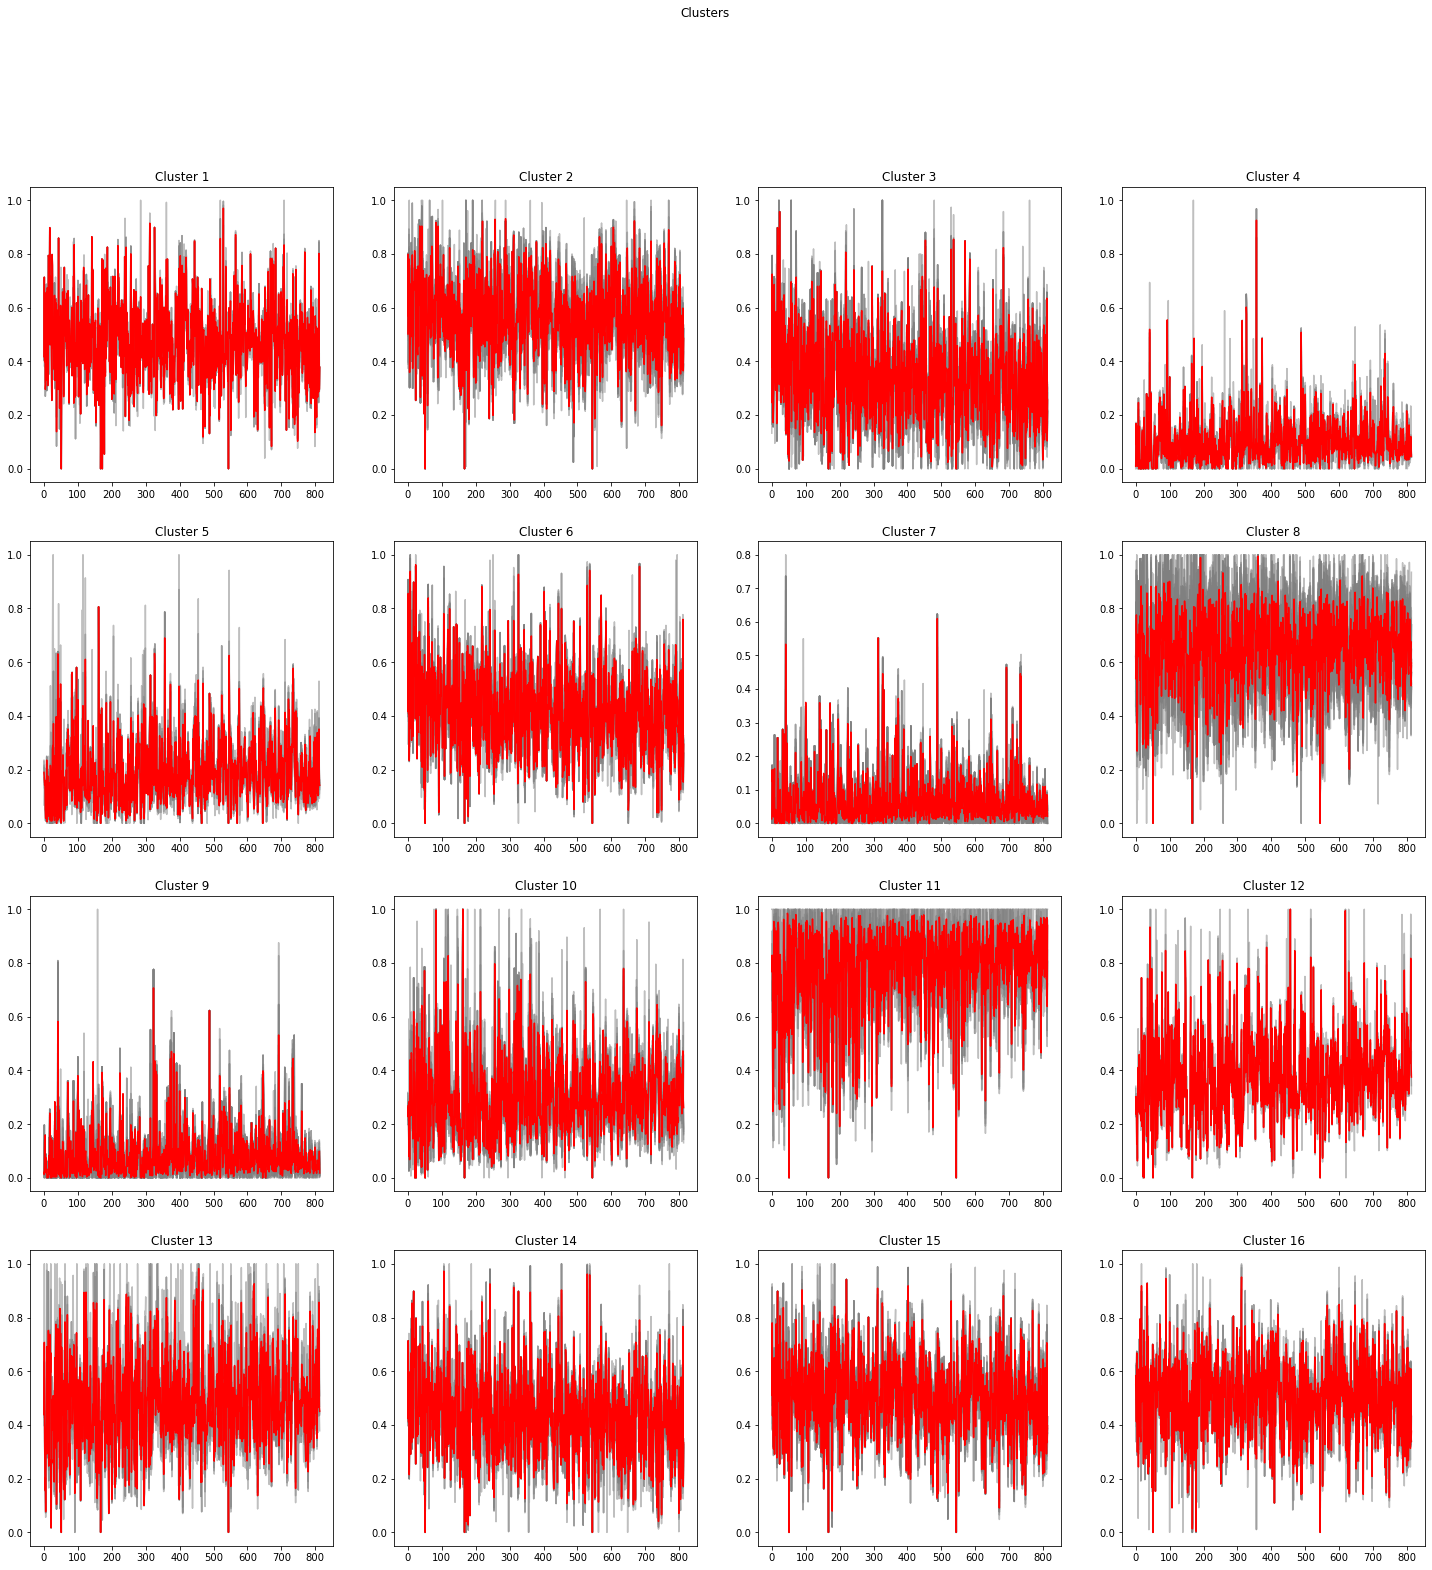

In [31]:
win_map = som.win_map(array_price_scaled)

plot_som_series_dba_center(som_x, som_y, win_map)

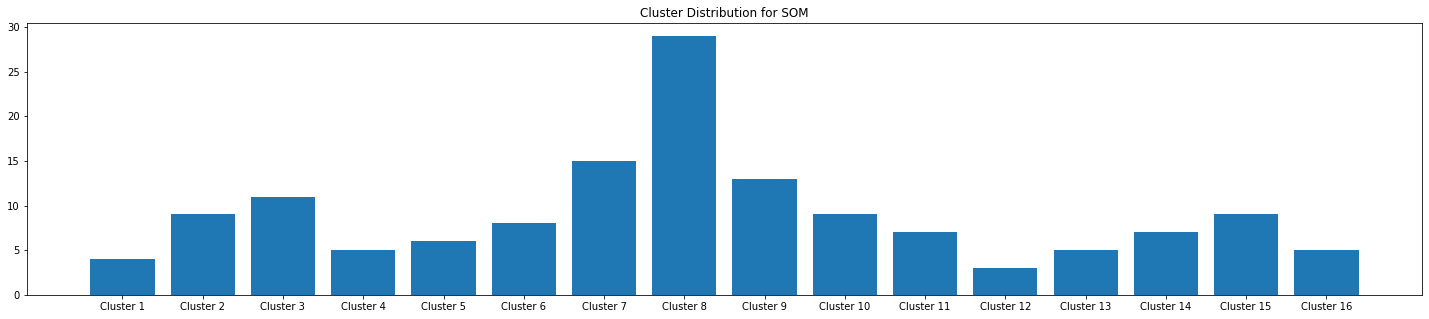

In [32]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

In [38]:
cluster_map = []
for idx in range(len(array_price_scaled)):
    winner_node = som.winner(array_price_scaled[idx])
    cluster_map.append((list_price_droped[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

df_cluster = pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

In [60]:
conn = DbEnv().connect_mongo('music_cow', 'daily_music_cow')

In [62]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 1"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['145', '148', '147', '146']
title: Pepe --- artist: CLC
title: If You Love Me --- artist: NS 윤지
title: 처음 느껴본 이별 --- artist: 정은지
title: 아무도 모르게 --- artist: 치타


In [63]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 2"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['123', '129', '128', '127', '126', '125', '124', '122', '121']
title: Beautiful Target --- artist: B1A4
title: 미운오리새끼 --- artist: god
title: 아이스크림 --- artist: MC몽
title: 도망가자 --- artist: MC몽
title: 못된 여자 --- artist: 원투
title: 죽도록 사랑해 --- artist: MC몽
title: 하늘색 약속 --- artist: god
title: 부산 바캉스 --- artist: 레게 강 같은 평화
title: Indian Boy --- artist: MC몽


In [64]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 3"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['178', '168', '169', '171', '173', '174', '175', '179', '177', '167', '176']
title: Simple Love --- artist: MC몽
title: IF... --- artist: B1A4
title: 오늘 밤 --- artist: 린
title: 동화 같은 사랑 --- artist: Apink
title: Luv D.N.A --- artist: MC몽
title: 너를 원해 --- artist: 정기고
title: 마지막 그 한마디 --- artist: 이승기
title: 유리 심장 --- artist: 린
title: 호러쇼 --- artist: MC몽
title: Good Good Time --- artist: 코요태
title: 죽을만큼 아파서 Part.2 --- artist: MC몽


In [65]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 4"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['54', '55', '56', '57', '58']
title: Rap Star --- artist: 스윙스
title: Tic Toc --- artist: 매드클라운
title: Would You Be My --- artist: 팔로알토
title: 꽃 --- artist: 매드클라운
title: 둘만 아는 말투 --- artist: 제리케이


In [66]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 5"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['64', '63', '62', '61', '60', '59']
title: 심상치 않아 --- artist: 키썸
title: 기억에게 외치다 --- artist: 장우혁
title: 예쁜 나이 25살 --- artist: 송지은
title: 링마벨 --- artist: 걸스데이
title: 다툼 --- artist: 제리케이
title: Femme Fatale --- artist: 스윙스


In [67]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 6"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['158', '163', '164', '165', '161', '157', '159', '160']
title: I'm In Love --- artist: 시크릿
title: 권태중독 --- artist: MC몽
title: So Fresh --- artist: MC몽
title: New York --- artist: MC몽
title: 천하무적 --- artist: MC몽
title: Good-night Kiss --- artist: 전효성
title: 그래도 남자니까 --- artist: MC몽
title: 넌 너무 야해 --- artist: 씨스타


In [68]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 7"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['53', '52', '51', '50', '42', '49', '48', '47', '46', '45', '39', '40', '41', '44', '43']
title: 때려박는 랩 --- artist: 매드클라운
title: 바질 --- artist: 매드클라운
title: 화 --- artist: 매드클라운
title: Fly --- artist: SUPER JUNIOR-K.R.Y.
title: 안녕 --- artist: 박혜경
title: 기억할게요 --- artist: 양파
title: 너와 함께 --- artist: 울랄라세션
title: 가슴앓이 --- artist: 바비 킴
title: 서울사람들 --- artist: 버스커 버스커
title: Dream --- artist: 수지
title: 아버지 --- artist: 다이나믹 듀오
title: 난 네게 --- artist: 라디
title: 빨간 운동화 --- artist: 박혜경
title: Yesterday --- artist: 박혜경
title: 하이힐 --- artist: 박혜경


In [69]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 8"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['98', '119', '82', '90', '91', '92', '93', '94', '120', '96', '97', '99', '100', '101', '102', '95', '104', '103', '118', '117', '116', '114', '115', '111', '110', '108', '107', '106', '112']
title: 서커스 --- artist: MC몽
title: 다시 --- artist: 터보
title: 나를 잊지 말아요 --- artist: 허각
title: HONEY BEE --- artist: 루나
title: 하늘바라기 --- artist: 정은지
title: Mr. Chu --- artist: Apink
title: 널 너무 사랑해서 --- artist: MC몽
title: 너란 봄 --- artist: 정은지
title: 대박사건 --- artist: B.A.P
title: Loving U --- artist: 씨스타
title: 거북이 --- artist: 다비치
title: Something --- artist: 걸스데이
title: I Need You --- artist: 허각
title: 내 생애 가장 행복한 시간 --- artist: MC몽
title: 너에게 쓰는 편지 --- artist: MC몽
title: Darling --- artist: 걸스데이
title: Give It To Me --- artist: 씨스타
title: I Love U Oh Thank U --- artist: MC몽
title: 죽을 만큼 아파서 --- artist: MC몽
title: 너나 잘해 --- artist: 에일리
title: 맘마미아 --- artist: 카라
title: 반창고 --- artist: 허각
title: 짧은머리 --- artist: 허각
title: 사랑 범벅 --- artist: MC몽
title: 미치겠어 --- artist: MC몽
title: 너에게 닿기를 --- artist: 우주소

In [70]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 9"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['30', '27', '28', '29', '31', '38', '33', '34', '35', '36', '37', '32', '26']
title: 오랜만이죠 --- artist: 라디
title: 연애시대 --- artist: 이승기
title: 엄마 --- artist: 라디
title: I Can't --- artist: 2PM
title: My Style --- artist: 조PD
title: 어떤 설레임 --- artist: 라디
title: Couple Song --- artist: 라디
title: 어머니의 된장국 --- artist: 다이나믹 듀오
title: 너와 함께 있음을 --- artist: 라디
title: Goodbye --- artist: 라디
title: Happy Birthday --- artist: 라디
title: 고마워고마워 --- artist: 라디
title: I'm in love --- artist: 라디


In [71]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 10"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['72', '65', '73', '67', '71', '66', '69', '68', '70']
title: 사고쳤어요 --- artist: 다비치
title: 이상하다 참 --- artist: 민아
title: 저녁하늘 --- artist: 에일리
title: 1분 1초 --- artist: 지연
title: 그 중에 그대를 만나 --- artist: 이선희
title: 예쁘다 --- artist: 에어플레인
title: 너만 봐 --- artist: 유지
title: White Day --- artist: 걸스데이
title: If You --- artist: 에일리


In [34]:
cluster_count = math.ceil(math.sqrt(len(array_price_scaled))) 

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(array_price_scaled)

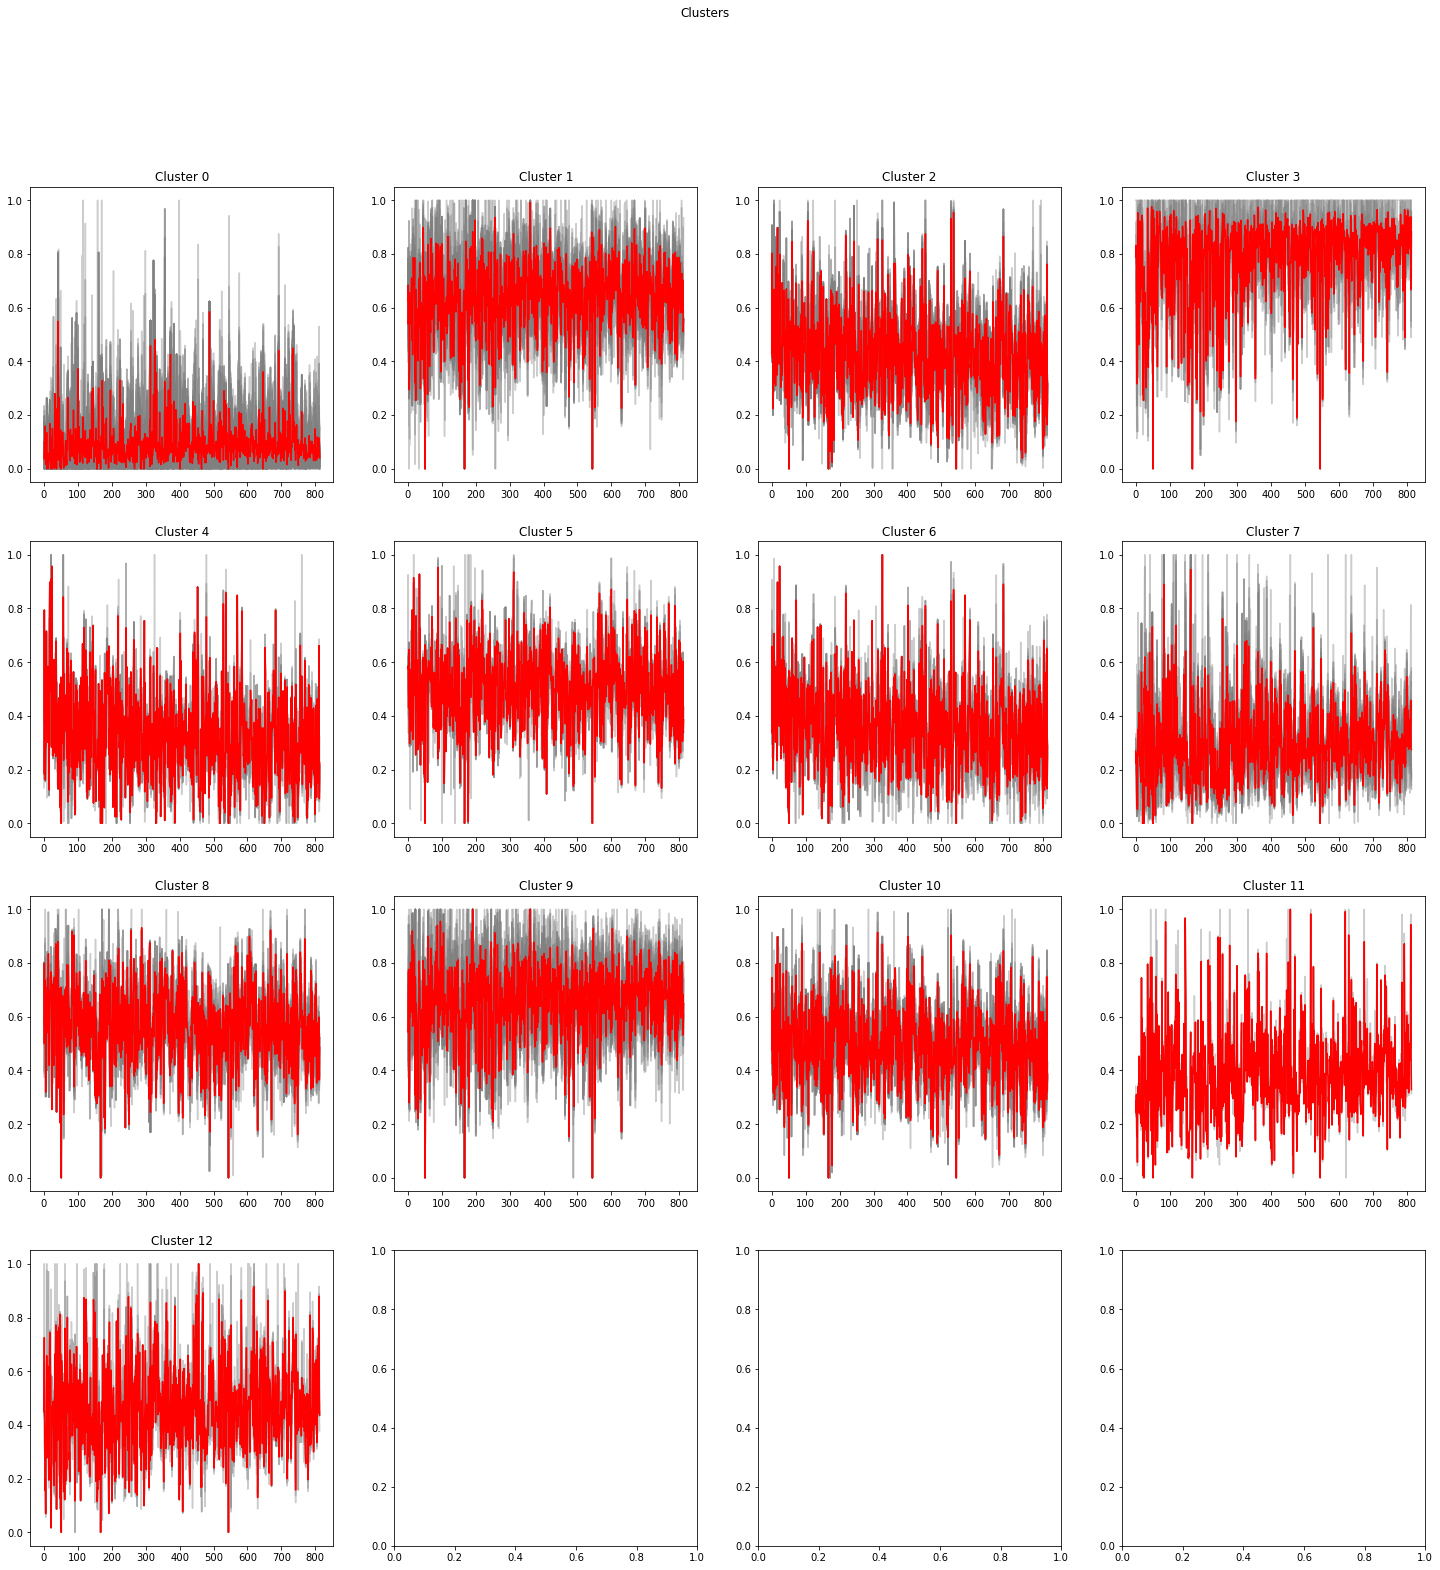

In [37]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0

for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(array_price_scaled[i],c="gray",alpha=0.4)
                cluster.append(array_price_scaled[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()